In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [3]:
# the activation map initialization varies independently from the class
# we can now add a new activation map initialization without changing the code -> more
# flexibility, extendability
# ???
# the example is a bit artificial

# smells that remain
# need to do the bookkeeping for i, j in case you want to create / simulate entire trajectories
# changing the next step probability is going to be trouble


def flat_activation_map_initializer(size):
    return np.ones((size, size))


def hills_activation_map_initializer(size):
    grid_ii, grid_jj = np.mgrid[0:size, 0:size]
    i_waves = np.sin(grid_ii/130) + np.sin(grid_ii/10)
    i_waves /= i_waves.max()
    j_waves = np.sin(grid_jj/100) + np.sin(grid_jj/50)+ np.sin(grid_jj/10)
    j_waves /= j_waves.max()
    activation_map = j_waves + i_waves
    return activation_map


def labyrinth_activation_map_initializer(size):
    activation_map = np.ones((size, size))
    activation_map[50:100, 50:60] = 0
    activation_map[20:89, 80:90] = 0
    activation_map[90:120, 0:10] = 0
    activation_map[120:size, 30:40] = 0
    activation_map[180:190, 50:60] = 0

    activation_map[50:60, 50:200] = 0
    activation_map[179:189, 80:130] = 0
    activation_map[110:120, 0:190] = 0
    activation_map[120:size, 30:40] = 0
    activation_map[180:190, 50:60] = 0

    return activation_map


class Walker:

    def __init__(self, sigma_i, sigma_j, size, activation_map):
        self.sigma_i = sigma_i
        self.sigma_j = sigma_j
        self.size = size
        self.activation_map = activation_map

        self._grid_ii, self._grid_jj = np.mgrid[0:size, 0:size]

    @classmethod
    def from_activation_map_initializer(cls, sigma_i, sigma_j, size, initializer):
        activation_map = initializer(size)
        activation_map /= activation_map.sum()
        return cls(sigma_i, sigma_j, size, activation_map)

    def next_step_probability(self, current_i, current_j):
        grid_ii, grid_jj = self._grid_ii, self._grid_jj
        sigma_i, sigma_j = self.sigma_i, self.sigma_j

        rad = (
            (((grid_ii - current_i) ** 2) / (sigma_i ** 2))
            + (((grid_jj - current_j) ** 2)/ (sigma_j ** 2))
        )

        p_next_step = np.exp(-(rad / 2.0)) / (2.0 * np.pi * sigma_i * sigma_j)
        return p_next_step / p_next_step.sum()

    def _compute_selection_map(self, next_step_map):
        selection_map = next_step_map * self.activation_map
        selection_map /= selection_map.sum()
        return selection_map

    def sample_next_step(self, current_i, current_j, random_state=np.random):
        next_step_map = self.next_step_probability(current_i, current_j)
        selection_map = self._compute_selection_map(next_step_map)

        r = random_state.rand()
        cumulative_map = np.cumsum(selection_map)
        cumulative_map = cumulative_map.reshape(selection_map.shape)
        i_next, j_next = np.argwhere(cumulative_map >= r)[0]

        return i_next, j_next

    def evaluate_position(self, current_i, current_j):
        next_step_map = self.next_step_probability(current_i, current_j)
        selection_map = self._compute_selection_map(next_step_map)
        return selection_map[current_i, current_j]


def plot_trajectory(trajectory, activation_map):
    trajectory = np.asarray(trajectory)
    plt.matshow(activation_map)
    plt.plot(trajectory[:, 1], trajectory[:, 0])
    plt.show()


In [4]:
walker = Walker.from_activation_map_initializer(
    sigma_i=3,
    sigma_j=4,
    size=200,
    initializer=labyrinth_activation_map_initializer,
)

i, j = 100, 50
trajectory = []
for _ in range(1000):
    i, j = walker.sample_next_step(i, j)
    trajectory.append((i, j))

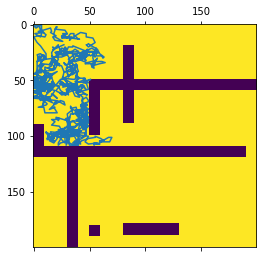

In [5]:
plot_trajectory(trajectory, walker.activation_map)
